In this example, we consider a 2D phase field model:

$$
E(\phi) = \int_{\Omega} \left( \frac{\kappa}{2} |\nabla \phi|^2 + \frac{1}{4} (1 - \phi^2)^2 \right) dx
$$

The Allen-Cahn equation is:

$$
\dot{\phi} = \kappa \Delta \phi + \phi - \phi^3
$$

We consider $\Omega = [0,1]^{2}$ with periodic boundary condition. 
We discrete it using finite difference scheme of mesh grids $64 \times 64$. 

First, we add the path of the `saddlescape-1.0` directory to the system path.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'saddlescape-1.0')))


Then, we import the main class.

In [2]:
from saddlescape import Landscape
import numpy as np

# import packages needed

We define the vector field by 2-D convolution.

In [3]:
from scipy.ndimage import convolve

def gradient_PF(x, opt):
	kappa = opt['kappa']
	n2 = len(x)
	n = int(np.sqrt(n2))
	phi = x.reshape(n, n)
	h = opt['h']

	D2 = np.array([[0, 1, 0],
				   [1, -4, 1],
				   [0, 1, 0]]) / h**2

	conv_term = convolve(phi, D2, mode='wrap')

	F = -(kappa * conv_term + phi - phi**3)

	return F.reshape(n2, 1)


Then, we define the judgement function with normalized cross-correlation based on Fast Fourier Transform(FFT).

In [4]:
from numpy.fft import fft2, ifft2

def SameSaddle(x, y):
    """
    Determine if two solutions are equivalent under periodic translation
    using normalized cross-correlation based on Fast Fourier Transform.
    """
    n = 64
    A = x.reshape(n, n)  
    B = y.reshape(n, n)  

    # 2D Fourier transform
    fft_A = fft2(A)
    fft_B = fft2(B)
    
    # Calculate cross-correlation spectrum in frequency domain
    cross_corr_spectrum = np.conj(fft_A) * fft_B
    
    # Inverse transform back to real space
    real_space_corr = np.real(ifft2(cross_corr_spectrum))
    
    # Find maximum correlation value
    max_corr = np.max(real_space_corr)
    
    # Normalization factor (energy of A)
    norm_factor = np.sum(A**2)
    if norm_factor < 1e-7:
        # Handle zero field case
        return np.sum(B**2) < 1e-7

    # Normalized peak correlation
    normalized_max_corr = max_corr / norm_factor

    # Threshold for equivalence judgment
    if normalized_max_corr > 0.99:
        return True
    
    return False

Define the system with $\kappa=0.02$.

In [5]:
N = 64
opt = {
	'kappa': 0.02,
	'N': N,
	'h': 1/N,
}

GradFunc = lambda x: gradient_PF(x, opt)


We initialize the solver and run it.

In [6]:
# parameter initialization
x0 = np.array([0 for i in range(N**2)]) # initial point
dt = 1e-3 # time step
k = 5
acceme = 'nesterov'
neschoice = 1
nesres = 200
mom = 0.8
maxiter = 2000 # max iter

In [7]:
MyLandscape = Landscape(MaxIndex=k, AutoDiff=False, Grad=GradFunc, DimerLength=1e-3, 
						HessianDimerLength=1e-3, EigenStepSize=1e-7, InitialPoint=x0, 
						TimeStep=dt, Acceleration=acceme, SearchArea=1e4, SymmetryCheck=False,
						Tolerance=1e-4, MaxIndexGap=3, EigenCombination='min',
						BBStep=True, NesterovChoice=neschoice, NesterovRestart=nesres, 
						Momentum=mom, MaxIter=maxiter, Verbose=True, ReportInterval=10, 
						EigenMaxIter=2, PerturbationNumber=2, EigvecUnified=True,SaveTrajectory=False,
						SameJudgementMethod=SameSaddle, PerturbationRadius=5.0)
# Instantiation
MyLandscape.Run()
# Calculate

HiSD Solver Configuration:
------------------------------
[HiSD] Current parameters (initialized):
[Config Sync] `Dim` parameter auto-adjusted to 4096 based on `InitialPoint` dimensionality.
Parameter `NumericalGrad` not specified - using default value False.
Parameter `EigenMethod` not specified - using default value lobpcg.
Parameter `ExactHessian` not specified - using default value False.
Parameter `PrecisionTol` not specified - using default value 1e-05.
Parameter 'GradientSystem' not provided. Enabling automatic symmetry detection.


Non-gradient system detected. Activating GHiSD algorithm.
'lobpcg' incompatible with non-gradient systems. Reverting to 'power' method.


Landscape Configuration:
------------------------------
[Landscape] Current parameters (initialized):
Parameter `PerturbationMethod` not specified - using default value uniform.
Parameter `InitialEigenVectors` not specified - using default value None.

Start running:
------------------------------



From initial p

We can draw the solution landscape and save the data.

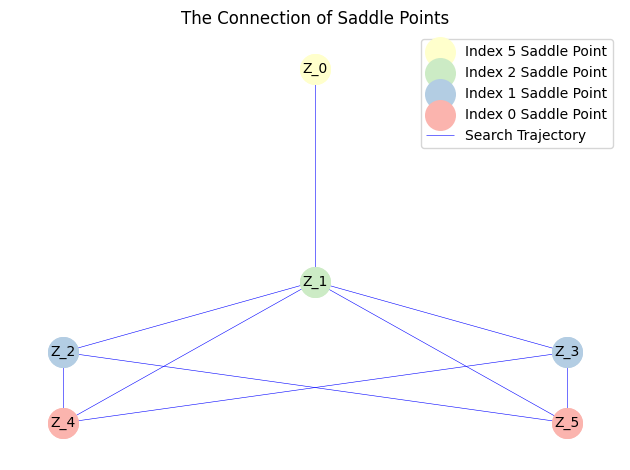

In [ ]:
MyLandscape.DrawConnection()
MyLandscape.Save('output/Ex_PhaseField','mat')
# Save the data

Then, we can draw the function by post-processing.

In [9]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_phi_heatmap(phi_vector, N):
	if len(phi_vector) != N * N:
		raise ValueError(f"Input shape must be {N * N}, but got {len(phi_vector)}")
	
	h=1/N

	x = np.linspace(h/2, 1-h/2, N)
	y = np.linspace(h/2, 1-h/2, N)
	X, Y = np.meshgrid(x, y)

	phi = phi_vector.reshape((N, N))

	grid_x, grid_y = np.mgrid[0:1:N*10j, 0:1:N*10j] 
	grid_phi = griddata((X.flatten(), Y.flatten()), phi.flatten(), (grid_x, grid_y), method='cubic')

	# Draw heatmap
	plt.figure(figsize=(8, 6))
	plt.imshow(grid_phi, extent=(0, 1, 0, 1), origin='lower', cmap='viridis',vmin=-1, vmax=1)
	plt.colorbar(label='$\phi$ value')
	plt.title('phase field $\phi$ heatmap')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.show()

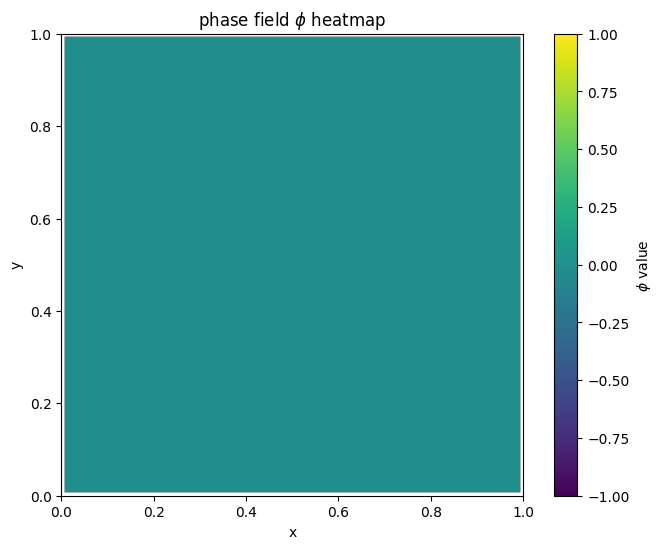

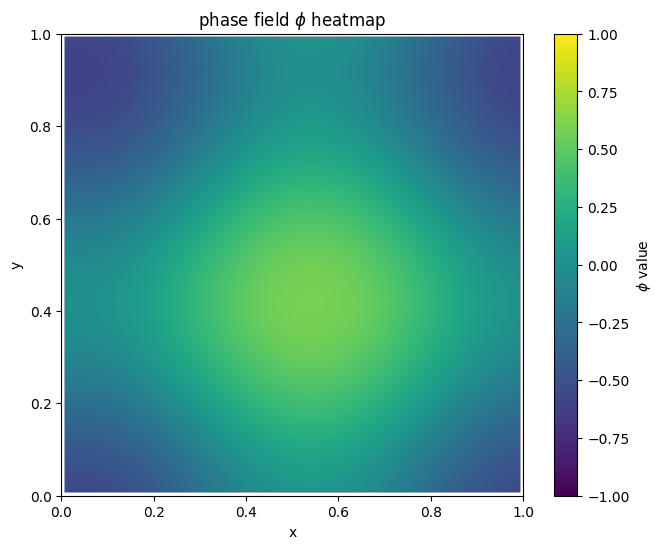

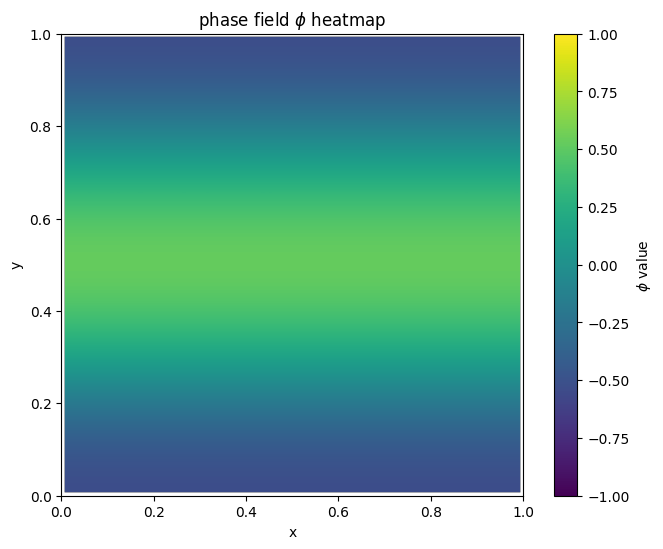

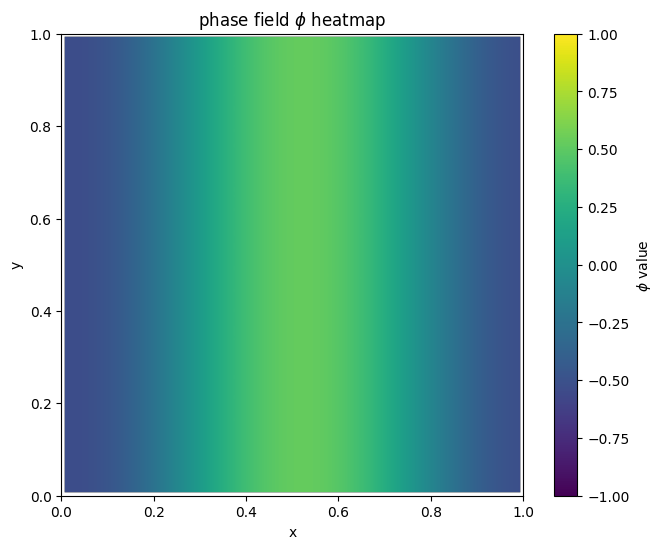

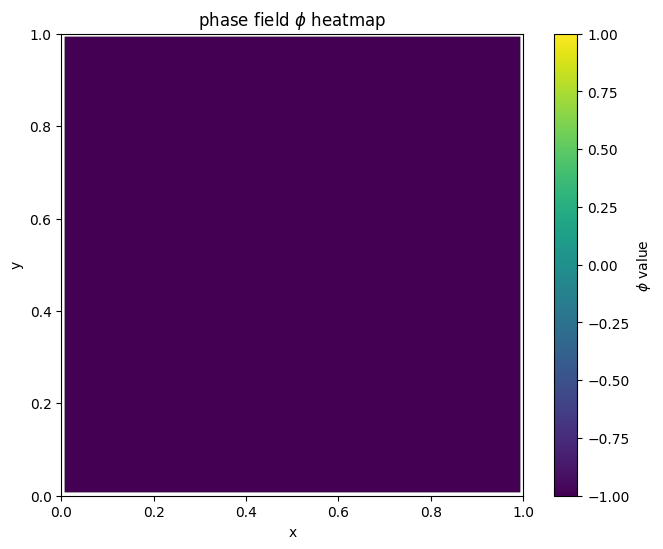

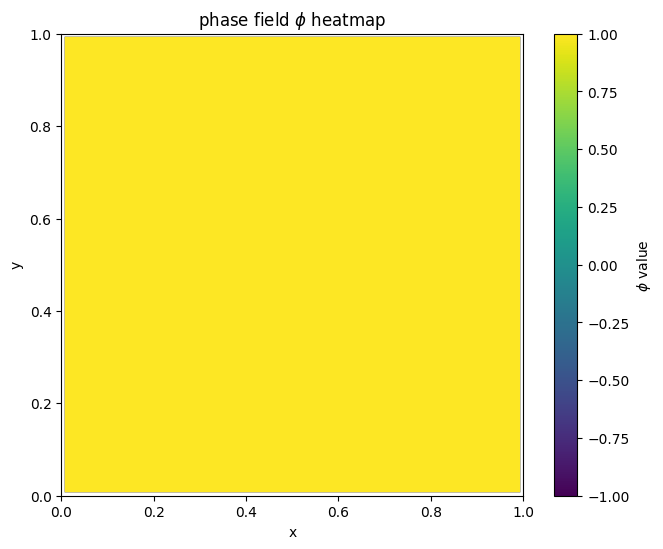

In [10]:
for i in range(len(MyLandscape.SaddleList)):
	plot_phi_heatmap(MyLandscape.SaddleList[i][1],N)